# NicheCompass - Lung ST 
data from  https://www.nature.com/articles/s12276-022-00896-9#Sec2

Use Environment: py3_9_R4_30

In [1]:
import sys
print("Python Version:", sys.version)

# Check if running inside a Conda environment
import os
if "CONDA_DEFAULT_ENV" in os.environ:
    conda_env_name = os.environ["CONDA_DEFAULT_ENV"]
    print("Active Conda Environment:", conda_env_name)
else:
    print("Not using Conda environment.")

Python Version: 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:36:46) 
[Clang 16.0.6 ]
Active Conda Environment: py3_9_R4_30


## 1. Import packages

In [2]:
import os
import random
import warnings
from datetime import datetime
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/spatialdata/__init__.py:11: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [3]:
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                extract_gp_dict_from_collectri_tf_network,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_gene_annotations,
                                generate_enriched_gp_info_plots,
                                generate_multimodal_mapping_dict,
                                get_unique_genes_from_gp_dict)

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
print(pd.__version__)

2.2.1


## Get Adata 
converted from rda

In [5]:
adata_2 = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata_2

100%|██████████| 9.26M/9.26M [00:01<00:00, 5.66MB/s]
100%|██████████| 20.1M/20.1M [00:04<00:00, 4.89MB/s]
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
adata = sc.read_h5ad('data/seurat_ST1.h5ad')
adata

AnnData object with n_obs × n_vars = 4095 × 36601
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial'
    var: 'features'

In [9]:
obs = pd.read_csv('data/seurat_ST1_obs.csv', sep = ' ')
obs.columns = ['in_tissue', 'array_row', 'array_col']

In [10]:
adata.obs = obs.copy()

In [11]:
adata.uns = adata_2.uns.copy()

In [12]:
obsm = pd.read_csv('data/seurat_ST1_obsm.csv', sep = ' ')
obsm = np.array(obsm)
obsm_list = list()
for i in range(len(obsm)):
    obsm_list.append([obsm[i][1], obsm[i][0]])
np.array(obsm_list)

adata.obsm['spatial'] = np.array(obsm_list)

In [13]:
imageR = np.array(pd.read_csv('data/seurat_ST1_imageR.csv', sep = ' '))
imageG = np.array(pd.read_csv('data/seurat_ST1_imageG.csv', sep = ' '))
imageB = np.array(pd.read_csv('data/seurat_ST1_imageB.csv', sep = ' '))

image_list3D = list()
for i in range(len(np.array(imageR))):
    image_list2D = list()
    for j in range(len(np.array(imageR)[1])):
        image_list2D.append([imageR[i][j], imageG[i][j], imageB[i][j]])
        
    image_list3D.append(image_list2D)
hires = np.array(image_list3D)

adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['images']['hires'] = hires.copy()

In [14]:
spot_diameter = pd.read_csv('data/seurat_ST1_spot_diameter.csv', sep = ' ')
hires_scalef = pd.read_csv('data/seurat_ST1_hires_scalef.csv', sep = ' ')
fiducial_diameter = pd.read_csv('data/seurat_ST1_fiducial_diameter.csv', sep = ' ')

adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['scalefactors']['spot_diameter_fullres'] = 150
adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['scalefactors']['tissue_hires_scalef'] = hires_scalef['x'][1]
adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['scalefactors']['fiducial_diameter_fullres'] = fiducial_diameter['x'][1]


In [15]:
adata

AnnData object with n_obs × n_vars = 4095 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'features'
    uns: 'spatial'
    obsm: 'spatial'

# Start NicheCompass

### 1.2 Define Parameters

In [51]:
### Dataset ###
dataset = "lung_ST" # starmap_plus_mouse_cns
species = "human" 
spatial_key = "spatial"
n_neighbors = 4

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "in_tissue" # Main_molecular_cell_type
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [17]:
warnings.filterwarnings("ignore")
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [19]:
# Define paths
ga_data_folder_path = "data/gene_annotations"
gp_data_folder_path = "data/gene_programs"
so_data_folder_path = "data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/figures"

In [20]:
f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"

'data/gene_annotations/human_mouse_gene_orthologs.csv'

### 1.5 Create Directories

In [21]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

### 1.6 Download the files used in this tutorial (optional)

In [11]:
'''
gdown.download('https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99', so_data_folder_path+'/starmap_plus_mouse_cns_batch1.h5ad')
'''

"\ngdown.download('https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99', so_data_folder_path+'/starmap_plus_mouse_cns_batch1.h5ad')\n"

## 2. Prepare Model Training
### 2.1 Create Prior Knowledge Gene Program (GP) Mask
NicheCompass expects a prior GP mask as input, which it will use to make its latent feature space interpretable (through linear masked decoders).

The user can provide a custom GP mask to NicheCompass based on the biological question of interest.

As a default, here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways:

OmniPath (Ligand-Receptor GPs)

MEBOCOST (Enzyme-Sensor GPs)

NicheNet (Combined Interaction GPs)

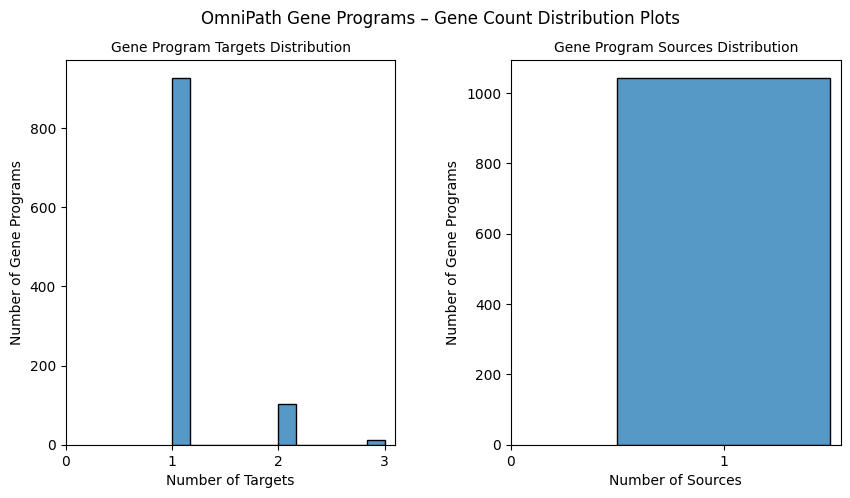

In [22]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [23]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

NTN4_ligand_receptor_GP: {'sources': ['NTN4'], 'targets': ['UNC5D'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


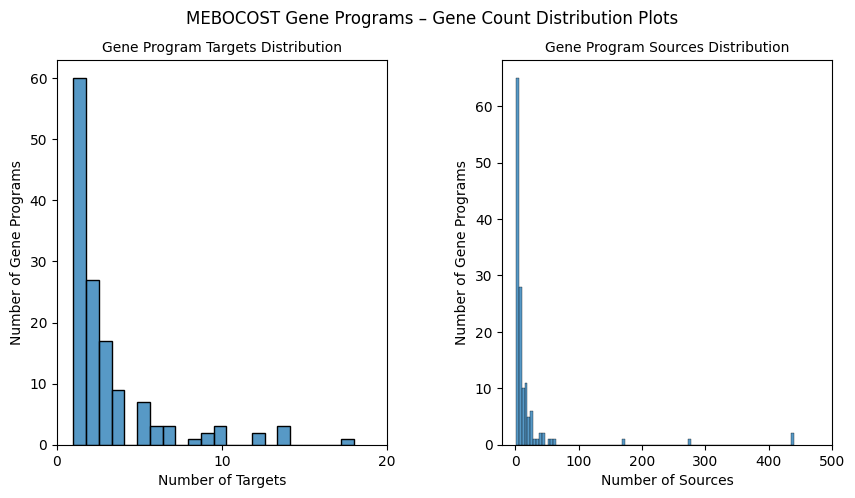

In [24]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [25]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Hypoxanthine_metabolite_enzyme_sensor_GP: {'sources': ['HPRT1', 'PNP', 'XDH'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme'], 'targets': ['SLC29A2'], 'targets_categories': ['sensor']}


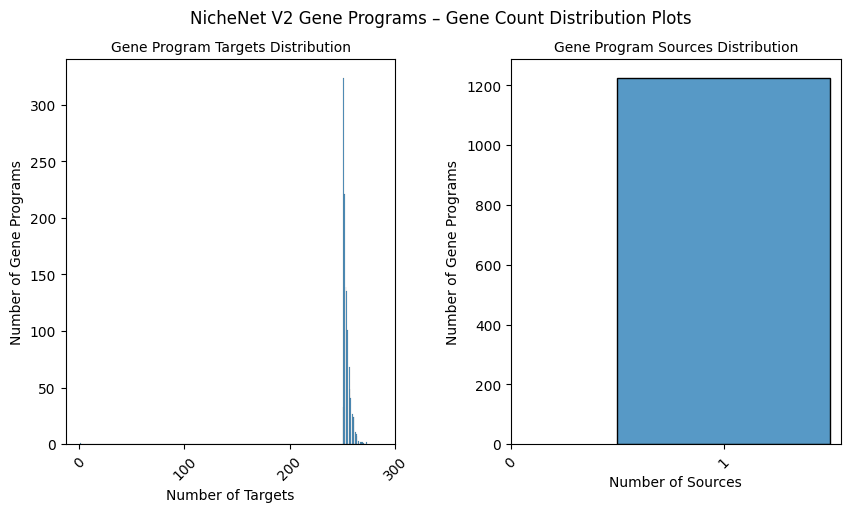

In [26]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [27]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

CDCP1_ligand_receptor_target_gene_GP: {'sources': ['CDCP1'], 'targets': ['EGFR', 'A2M', 'ABCC3', 'ACKR3', 'ADD3', 'ADM', 'AHNAK', 'AKT1', 'ANGPTL4', 'ANKRD1', 'APP', 'ARID5B', 'ASCL1', 'ASPH', 'ASS1', 'ATF3', 'BAX', 'BCL2', 'BCL2L1', 'BCL2L11', 'BCL3', 'BCL6', 'BDNF', 'BHLHE40', 'BIRC3', 'BIRC5', 'BMP4', 'BRCA1', 'BST2', 'BTG1', 'CAV1', 'CBX5', 'CCL2', 'CCL5', 'CCN1', 'CCN2', 'CCNA2', 'CCNB1', 'CCND1', 'CCND2', 'CCND3', 'CD44', 'CD83', 'CDH1', 'CDH3', 'CDK4', 'CDK6', 'CDKN1A', 'CDKN2A', 'CEACAM1', 'CEBPA', 'CEBPD', 'CEMIP', 'CEMIP2', 'CITED2', 'CKS1B', 'CLDN1', 'COL1A2', 'CSF2', 'CSGALNACT1', 'CTSH', 'CXADR', 'CXCL2', 'CXCL8', 'CXCR4', 'CYP1A1', 'CYP1B1', 'CYP27B1', 'DDIT3', 'DDIT4', 'DDX60', 'DHRS3', 'DKK1', 'DTL', 'DUSP1', 'DUSP4', 'DUSP5', 'DUSP6', 'EDN1', 'EFHD1', 'EFNA1', 'EGLN3', 'EGR1', 'EGR2', 'EGR3', 'ELF3', 'EMP1', 'EPAS1', 'EPHA2', 'ESR1', 'ETS1', 'ETS2', 'EZH2', 'FAS', 'FASN', 'FGF2', 'FN1', 'FOS', 'FOSL1', 'FOXO3', 'FST', 'GADD45A', 'GADD45B', 'GATA3', 'GBP2', 'GDF15', 'GF

In [28]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [29]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2406.
Number of gene programs after filtering and combining: 1987.


### 2.2 Load Data & Compute Spatial Neighbor Graph
NicheCompass expects a precomputed spatial adjacency matrix stored in ‘adata.obsp[adj_key]’.

The user can customize the spatial neighbor graph construction based on the biological question of interest.

In [30]:
adata

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


AnnData object with n_obs × n_vars = 4095 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'features'
    uns: 'spatial'
    obsm: 'spatial'

In [46]:
adata.obs

in_tissue  array_row  array_col
AAACAAGTATCTCCCA-1          1         50        102
AAACACCAATAACTGC-1          1         59         19
AAACAGAGCGACTCCT-1          1         14         94
AAACAGCTTTCAGAAG-1          1         43          9
AAACAGGGTCTATATT-1          1         47         13
...                       ...        ...        ...
TTGTTGTGTGTCAAGA-1          1         31         77
TTGTTTCACATCCAGG-1          1         58         42
TTGTTTCATTAGTCTA-1          1         60         30
TTGTTTCCATACAACT-1          1         45         27
TTGTTTGTATTACACG-1          1         73         41

[4095 rows x 3 columns]

In [40]:
# This is the example data
# Read data
adata.example = sc.read_h5ad(
        f"{so_data_folder_path}/starmap_plus_mouse_cns_batch1.h5ad")
adata.example

AnnData object with n_obs × n_vars = 91246 × 1022
    obs: 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'batch'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [50]:
adata.example.obs

Main_molecular_cell_type Sub_molecular_cell_type  \
sagittal1_0      Vascular and leptomeningeal cells                   VLM_1   
sagittal1_1                            Unannotated                    NA_2   
sagittal1_2      Vascular and leptomeningeal cells                   VLM_1   
sagittal1_3      Vascular and leptomeningeal cells                   VLM_2   
sagittal1_4      Vascular and leptomeningeal cells                   VLM_2   
...                                            ...                     ...   
sagittal1_91241  Vascular and leptomeningeal cells                   VLM_1   
sagittal1_91242  Vascular and leptomeningeal cells                   VLM_1   
sagittal1_91243  Vascular and leptomeningeal cells                   VLM_1   
sagittal1_91244  Vascular and leptomeningeal cells                   VLM_2   
sagittal1_91245  Vascular and leptomeningeal cells                   VLM_1   

                Main_molecular_tissue_region Sub_molecular_tissue_region  \
sagittal1_0                    L1_HPFmo_Mngs                       MNG_1   
sagittal1_1                    L1_HPFmo_Mngs                       MNG_1   
sagittal1_2                    L1_HPFmo_Mngs                       MNG_1   
sagittal1_3                    L1_HPFmo_Mngs                       MNG_1   
sagittal1_4                    L1_HPFmo_Mngs                       MNG_1   
...                                      ...                         ...   
sagittal1_91241                         CB_2                       MNG_1   
sagittal1_91242                         CB_2                       MNG_1   
sagittal1_91243                         CB_2                       MNG_1   
sagittal1_91244                         CB_2                       MNG_1   
sagittal1_91245                         CB_2                       MNG_1   

                Molecular_spatial_cell_type      batch  
sagittal1_0                     VLM_1-MNG_1  sagittal1  
sagittal1_1                      NA_2-MNG_1  sagittal1  
sagittal1_2                     VLM_1-MNG_1  sagittal1  
sagittal1_3                     VLM_2-MNG_1  sagittal1  
sagittal1_4                     VLM_2-MNG_1  sagittal1  
...                                     ...        ...  
sagittal1_91241                 VLM_1-MNG_1  sagittal1  
sagittal1_91242                 VLM_1-MNG_1  sagittal1  
sagittal1_91243                 VLM_1-MNG_1  sagittal1  
sagittal1_91244                 VLM_2-MNG_1  sagittal1  
sagittal1_91245                 VLM_1-MNG_1  sagittal1  

[91246 rows x 6 columns]

In [32]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Add GP Mask to Data

In [33]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.4 Explore Data

In [52]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

In [54]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=spot_size)        

KeyError: 'counts'

## 3. Train Model
### 3.1 Initialize, Train & Save Model

In [55]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

ValueError: Please specify an adequate ´counts_key´. By default the counts are assumed to be stored in data.layers['counts'].

The train model step is very slow, need OMIKA

In [26]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 82121
Number of validation nodes: 9125
Number of training edges: 195913
Number of validation edges: 21768
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1/5 |████----------------| 20.0% train_global_loss: 519575.4728; train_optim_loss: 519575.4728; val_global_loss: 488486.8622; val_optim_loss: 488486.8622
Epoch 2/5 |████████------------| 40.0% train_global_loss: 478676.1177; train_optim_loss: 478676.1177; val_global_loss: 476367.1307; val_optim_loss: 476367.1307
Epoch 3/5 |████████████--------| 60.0% train_global_loss: 469687.9256; train_optim_loss: 469687.9256; val_global_loss: 470788.5241; val_optim_loss: 470788.5241
Epoch 4/5 |████████████████----| 80.0% t

In [27]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [28]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Analysis

In [29]:
load_timestamp = "09022024_180928"
# load_timestamp = current_timestamp # uncomment if you trained the model in this notebook

figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"

figure_folder_path = f"/Users/yelin.zhao/Library/CloudStorage/OneDrive-Personal/Projects/Spatial/NicheCpass/artifacts/single_sample/figures"
model_folder_path = f"/Users/yelin.zhao/Library/CloudStorage/OneDrive-Personal/Projects/Spatial/NicheCpass/artifacts/single_sample/model"


os.makedirs(figure_folder_path, exist_ok=True)

In [30]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1022, n_cat_covariates_embed_input: 0, n_hidden: 313, n_latent: 213, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 213, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1022
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 213, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1022


In [31]:
samples = model.adata.obs[sample_key].unique().tolist()

## 4.1 Visualize NicheCompass Latent GP Space

In [32]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

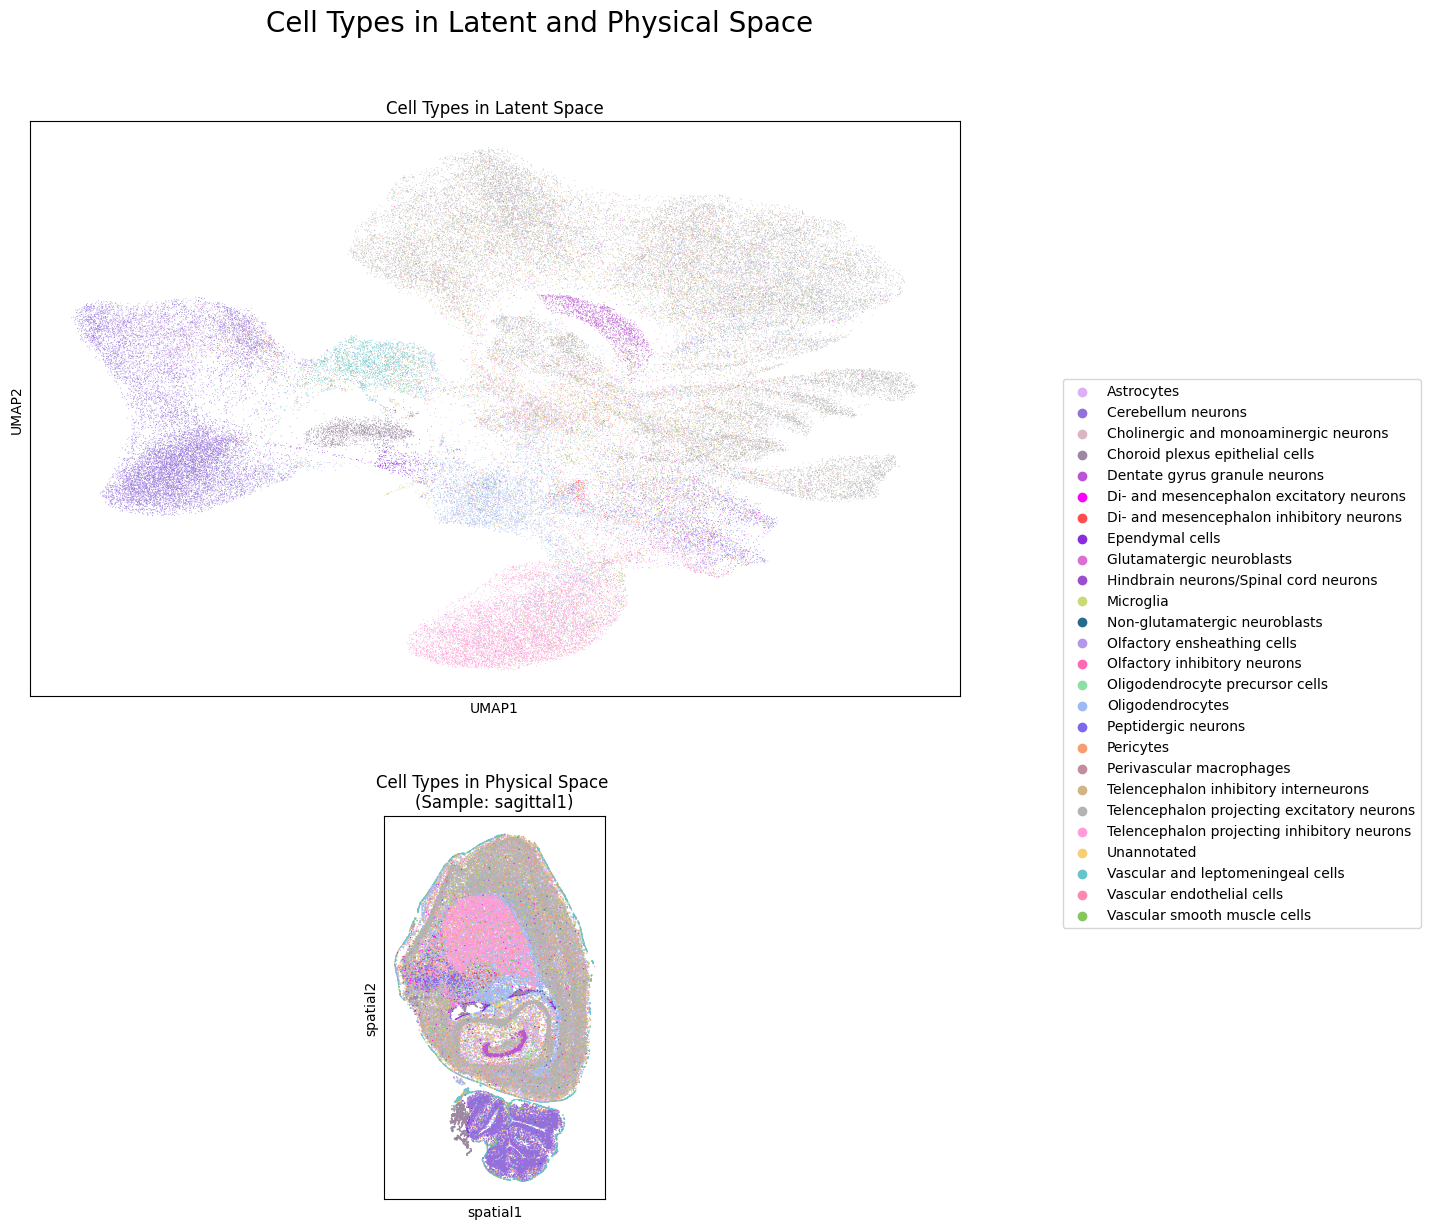

In [33]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

In [34]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [35]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

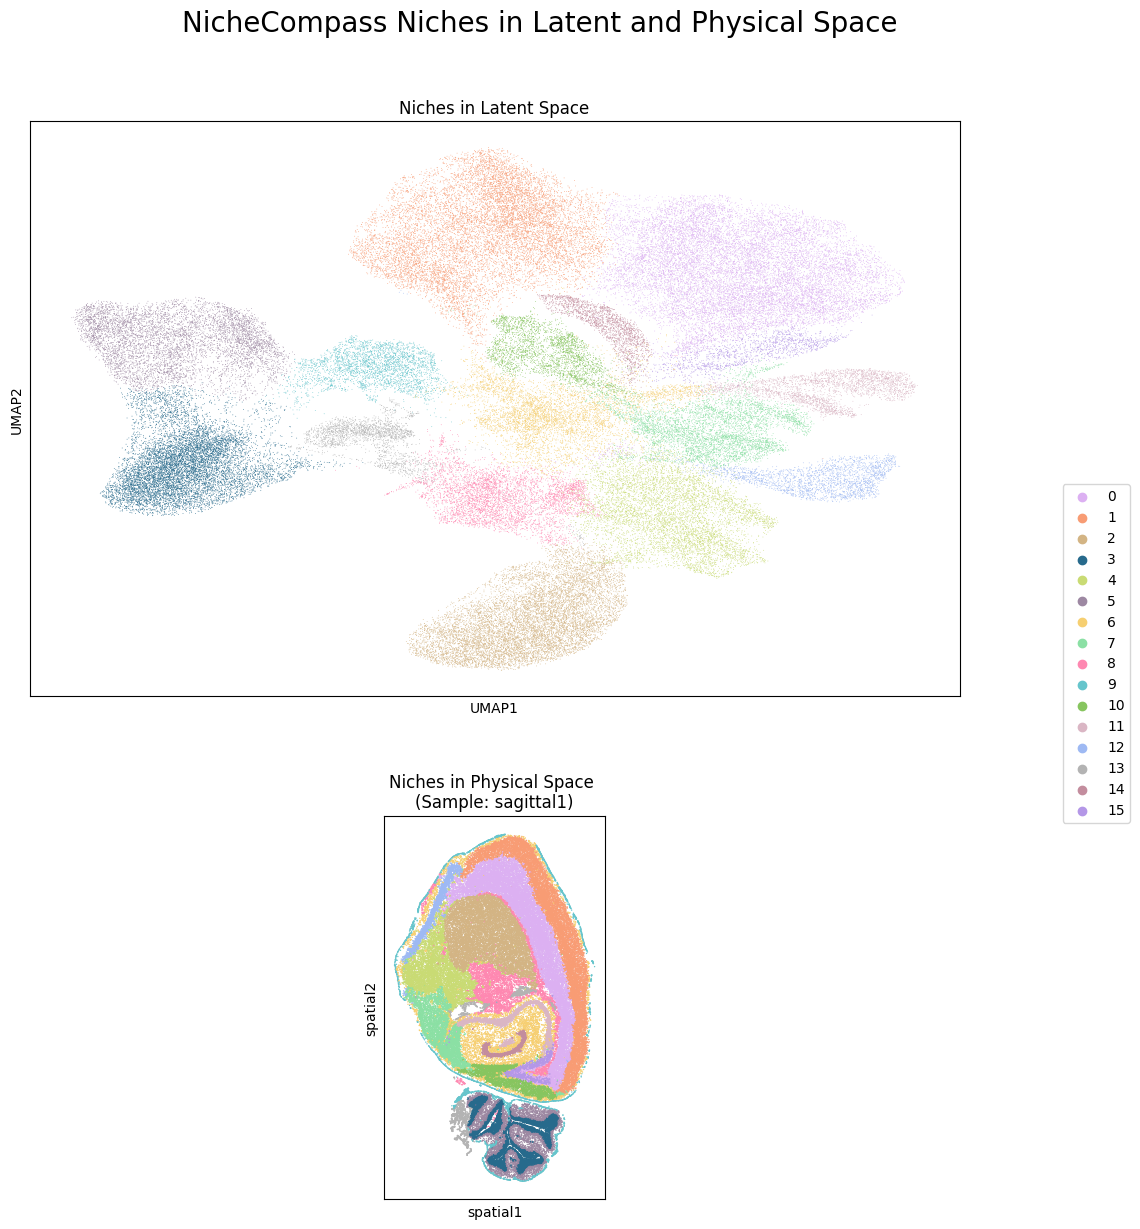

In [36]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

## 4.3 Characterize Niches
### 4.3.1 Niche Composition

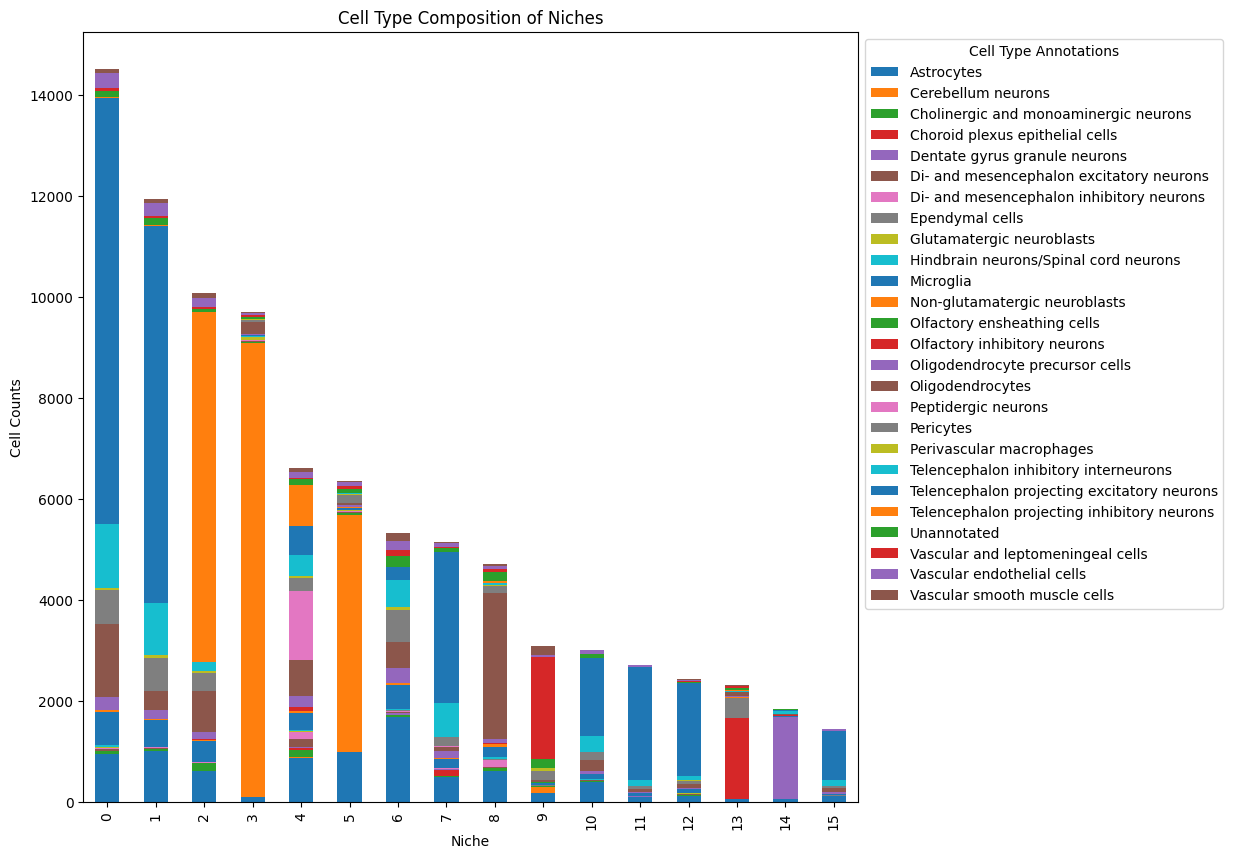

In [37]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

### 4.3.2 Differential GPs
Now we can test which GPs are differentially expressed in a niche. To this end, we will perform differential GP testing of a selected niche, e.g. niche “17” (selected_cats = ["17"]) vs all other niches (comparison_cats = "rest"). However, differential GP testing can also be performed in the following ways:

Set selected_cats = None to perform differential GP testing across all niches, as opposed to just for one specific niche.

Set comparison_cats = ["19"] to perform differential GP testing against niche “19” as opposed to against all other niches.

We choose an absolute log bayes factor threshold of 2.3 to determine strongly enriched GPs (see https://en.wikipedia.org/wiki/Bayes_factor).

In [38]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 313.
Number of active gene programs: 312.


In [39]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

gp_name  all_gp_idx  gp_active  active_gp_idx  \
0  IGF2_ligand_receptor_GP           0       True              0   
1   GRP_ligand_receptor_GP           1       True              1   
2   CCK_ligand_receptor_GP           2       True              2   
3  PDYN_ligand_receptor_GP           3       True              3   
4  PENK_ligand_receptor_GP           4       True              4   

   n_source_genes  n_non_zero_source_genes  n_target_genes  \
0               1                        1               1   
1               1                        1               1   
2               1                        1               1   
3               1                        1               1   
4               1                        1               1   

   n_non_zero_target_genes gp_source_genes gp_target_genes  \
0                        1          [IGF2]         [S1PR1]   
1                        1           [GRP]        [HSPA1A]   
2                        1           [CCK]          [CNR1]   
3                        1          [PDYN]         [OPRL1]   
4                        1          [PENK]          [GHSR]   

  gp_source_genes_weights gp_target_genes_weights gp_source_genes_importances  \
0               [-0.0169]               [-0.1489]                    [0.1017]   
1                [0.0891]                [0.0172]                    [0.8383]   
2                [0.3399]               [-0.1832]                    [0.6497]   
3               [-0.3399]               [-0.0269]                    [0.9266]   
4                 [0.235]                [0.0098]                    [0.9599]   

  gp_target_genes_importances  
0                    [0.8983]  
1                    [0.1617]  
2                    [0.3503]  
3                    [0.0734]  
4                    [0.0401]

In [42]:
# Set parameters for differential gp testing
selected_cats = ["15"]
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [50]:
f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

'/Users/yelin.zhao/Library/CloudStorage/OneDrive-Personal/Projects/Spatial/NicheCpass/artifacts/single_sample/figures//log_bayes_factor_2.3_niches_enriched_gps_heatmap.svg'

In [43]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [44]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

category                            gene_program      p_h0      p_h1  \
0        15   Sema5a_ligand_receptor_target_gene_GP  0.984564  0.015436   
1        15      Lum_ligand_receptor_target_gene_GP  0.017422  0.982578   
2        15   Sema3e_ligand_receptor_target_gene_GP  0.020889  0.979111   
3        15    Fbln2_ligand_receptor_target_gene_GP  0.023530  0.976470   
4        15   Hapln1_ligand_receptor_target_gene_GP  0.023559  0.976441   
5        15     Sost_ligand_receptor_target_gene_GP  0.975827  0.024173   
6        15  Col11a1_ligand_receptor_target_gene_GP  0.975709  0.024291   
7        15      Grp_ligand_receptor_target_gene_GP  0.974167  0.025833   
8        15   Adenosine_metabolite_enzyme_sensor_GP  0.031930  0.968070   
9        15     Il33_ligand_receptor_target_gene_GP  0.037000  0.963000   
10       15                            Add-on_15_GP  0.037671  0.962329   
11       15                            Add-on_57_GP  0.038415  0.961585   
12       15    Crhr2_ligand_receptor_target_gene_GP  0.040365  0.959635   
13       15    Ccl24_ligand_receptor_target_gene_GP  0.959630  0.040370   
14       15                            Add-on_54_GP  0.954603  0.045397   
15       15     Penk_ligand_receptor_target_gene_GP  0.047035  0.952965   
16       15     Nrtn_ligand_receptor_target_gene_GP  0.949862  0.050138   
17       15   Col9a2_ligand_receptor_target_gene_GP  0.053380  0.946620   
18       15                             Add-on_0_GP  0.059929  0.940071   
19       15      Cfh_ligand_receptor_target_gene_GP  0.939992  0.060008   
20       15     Prlh_ligand_receptor_target_gene_GP  0.068064  0.931936   
21       15                            Add-on_31_GP  0.931376  0.068624   
22       15                            Add-on_59_GP  0.930876  0.069124   
23       15      A2m_ligand_receptor_target_gene_GP  0.071408  0.928592   
24       15     Rln3_ligand_receptor_target_gene_GP  0.072252  0.927748   
25       15     Vcan_ligand_receptor_target_gene_GP  0.072386  0.927614   
26       15   Sema3a_ligand_receptor_target_gene_GP  0.924035  0.075965   
27       15                             Add-on_2_GP  0.922411  0.077589   
28       15     Agrp_ligand_receptor_target_gene_GP  0.920151  0.079849   
29       15     Pmch_ligand_receptor_target_gene_GP  0.916675  0.083325   
30       15    Anpep_ligand_receptor_target_gene_GP  0.089158  0.910842   
31       15      Tnr_ligand_receptor_target_gene_GP  0.910013  0.089987   
32       15      Ucn_ligand_receptor_target_gene_GP  0.090844  0.909156   

    log_bayes_factor  
0           4.155479  
1          -4.032460  
2          -3.847402  
3          -3.725651  
4          -3.724410  
5           3.698040  
6           3.693072  
7           3.629930  
8          -3.411751  
9          -3.259130  
10         -3.240471  
11         -3.220142  
12         -3.168577  
13          3.168449  
14          3.045853  
15         -3.008681  
16          2.941539  
17         -2.875469  
18         -2.752787  
19          2.751399  
20         -2.616814  
21          2.608027  
22          2.600231  
23         -2.565253  
24         -2.552597  
25         -2.550604  
26          2.498482  
27          2.475564  
28          2.444403  
29          2.398005  
30         -2.323956  
31          2.313796  
32         -2.303368

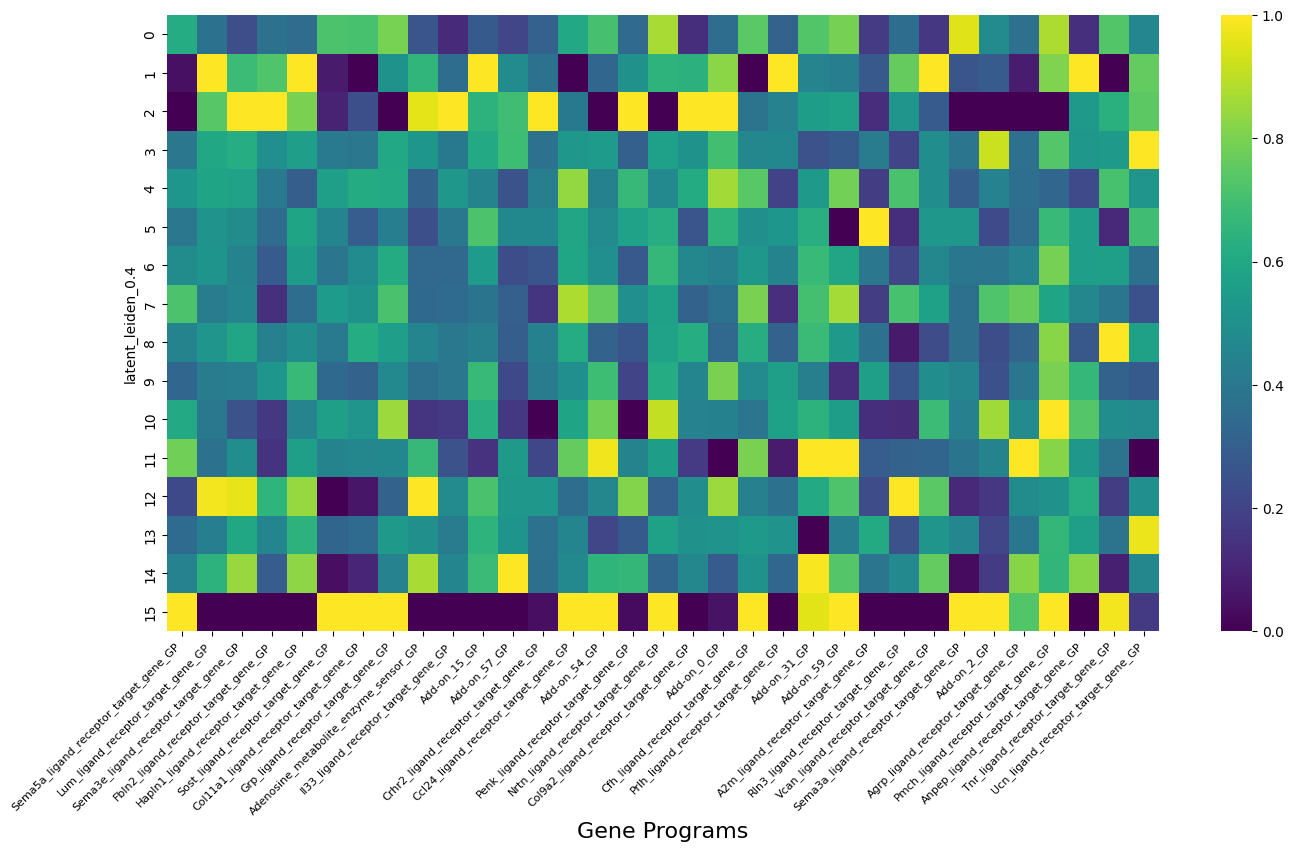

In [45]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [51]:
f"{figure_folder_path}" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

'/Users/yelin.zhao/Library/CloudStorage/OneDrive-Personal/Projects/Spatial/NicheCpass/artifacts/single_sample/figures/log_bayes_factor_2.3_niche_enriched_gps_summary.csv'

In [52]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

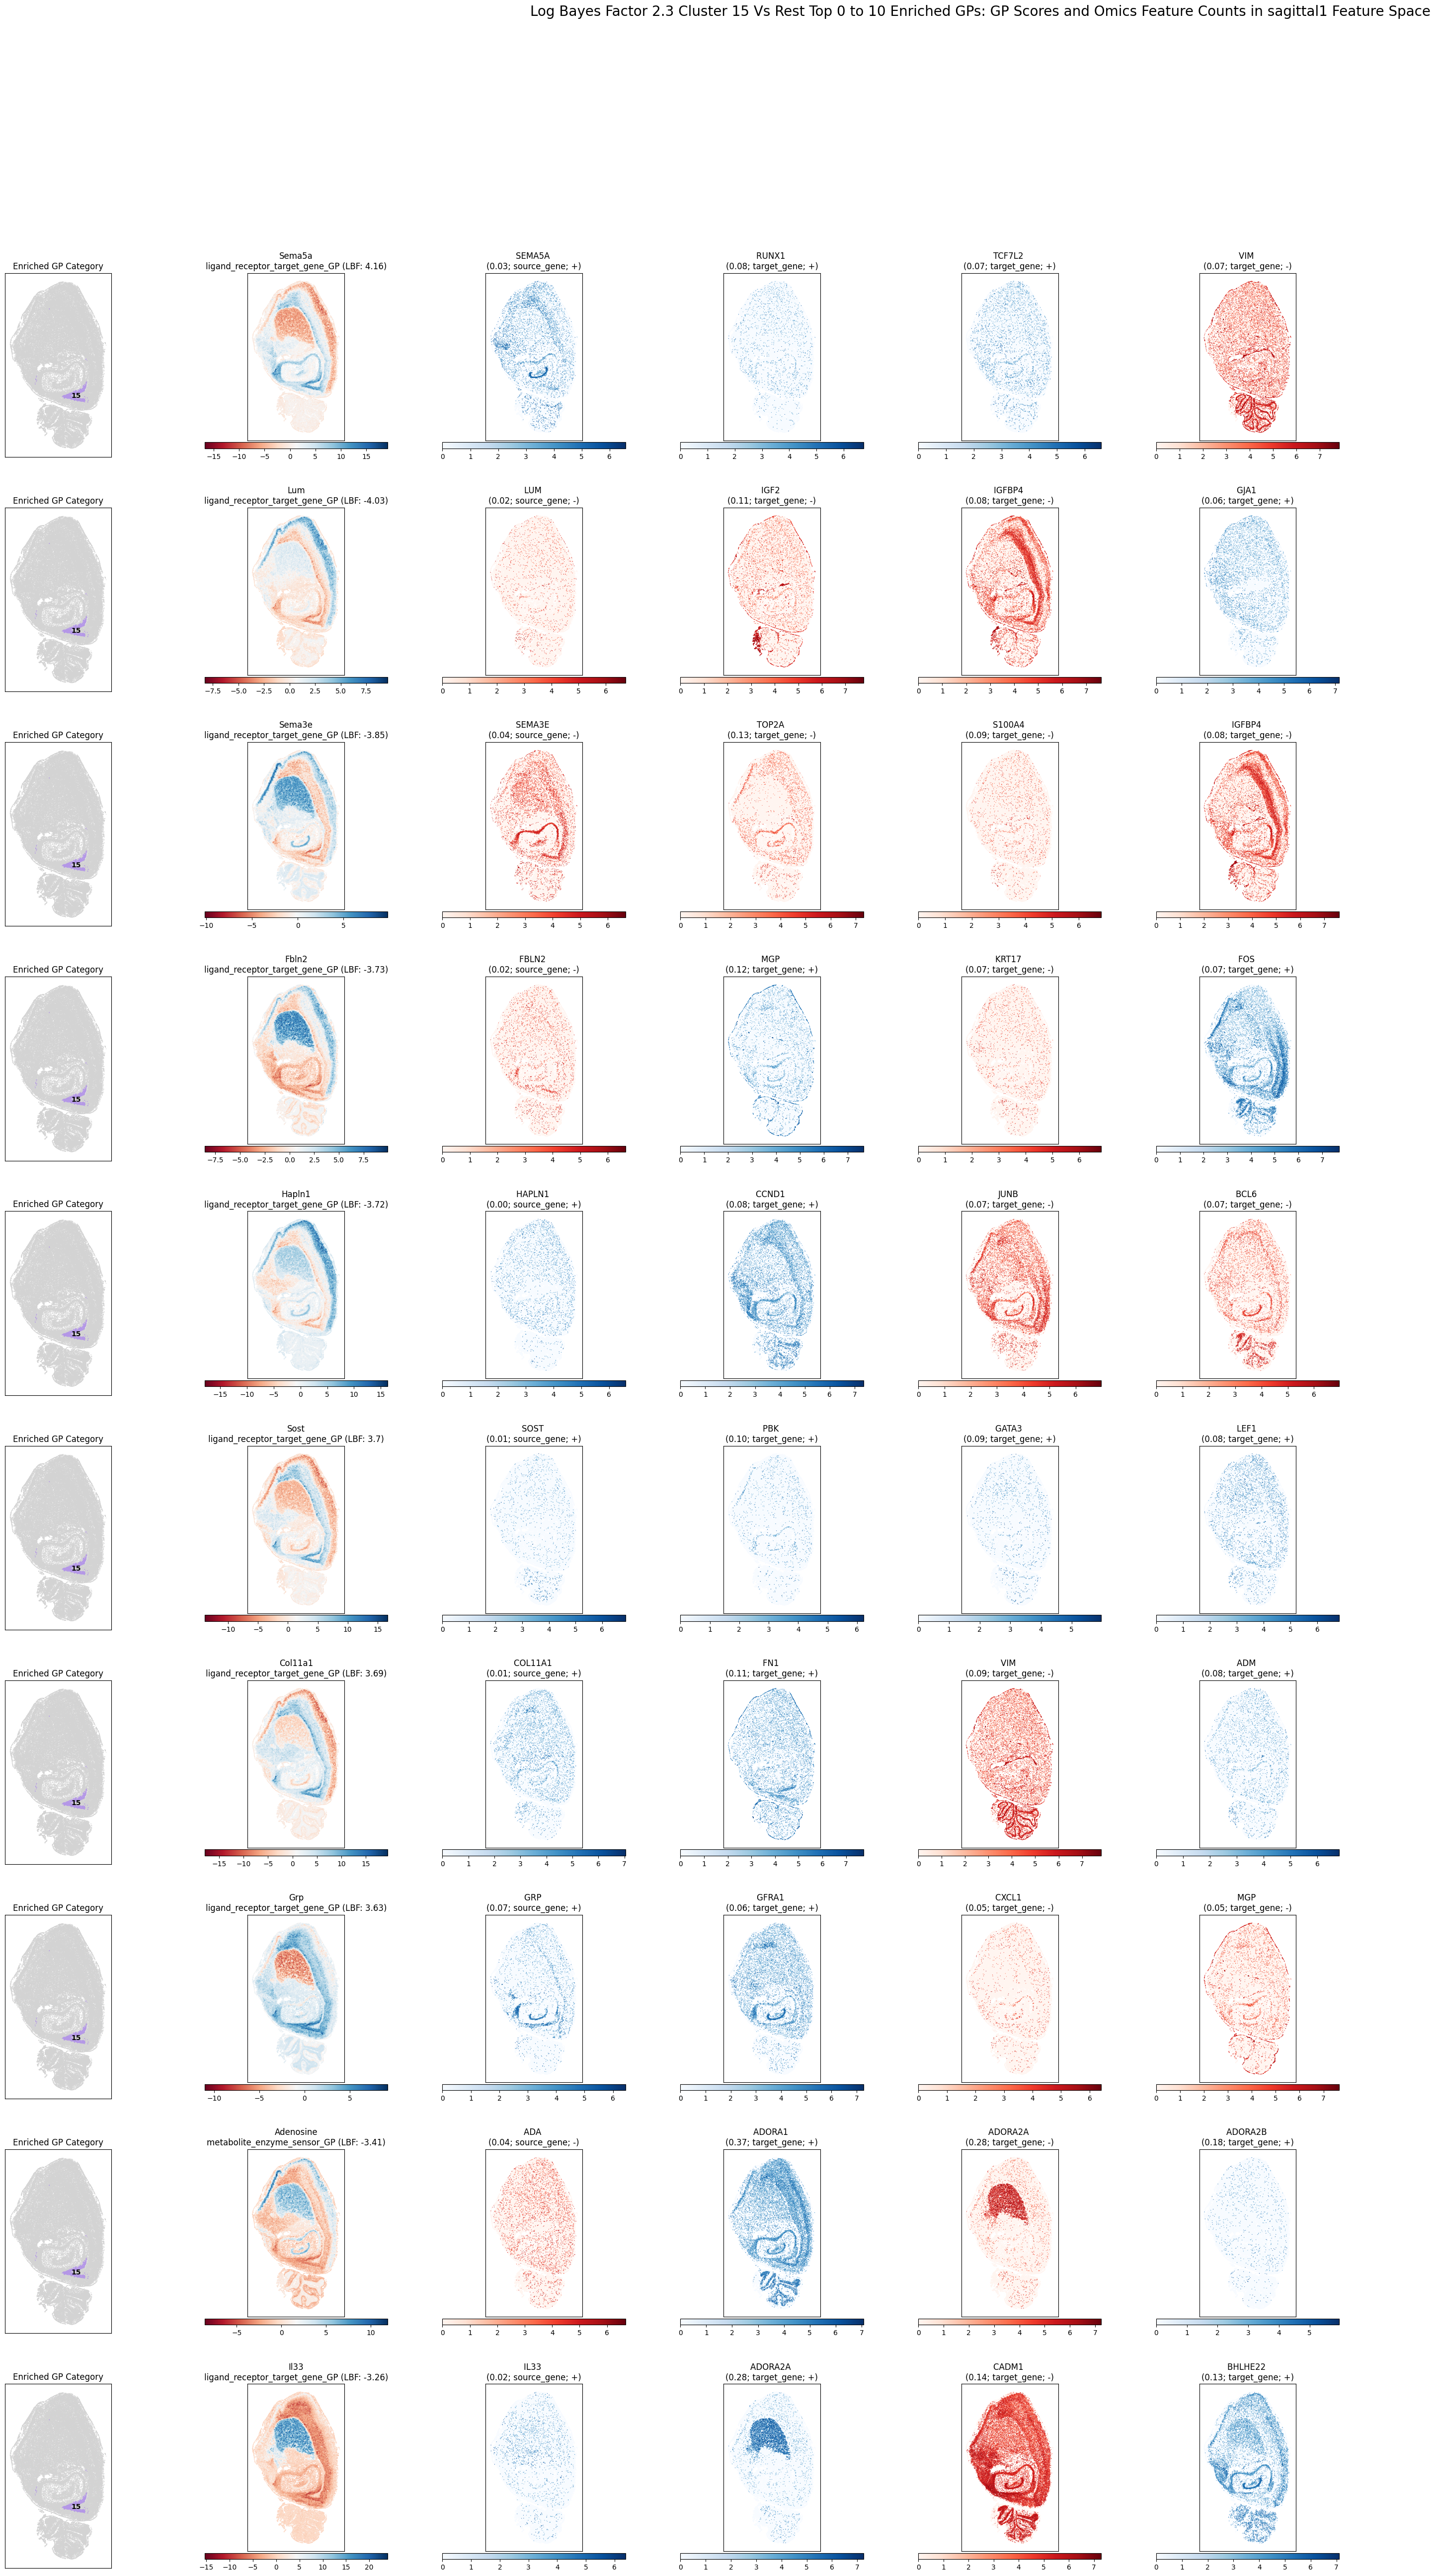

In [53]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_{selected_cats[0]}_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

### 4.3.3 Cell-cell Communication
Now we will use the inferred activity of an enriched combined interaction GP to analyze the involved intercellular interactions.

In [59]:
gp_name = "Ccl24_ligand_receptor_target_gene_GP" 
#Pdgfa_ligand_receptor_target_gene_GP, Kl_ligand_receptor_target_gene_GP, Grp_ligand_receptor_target_gene_GP

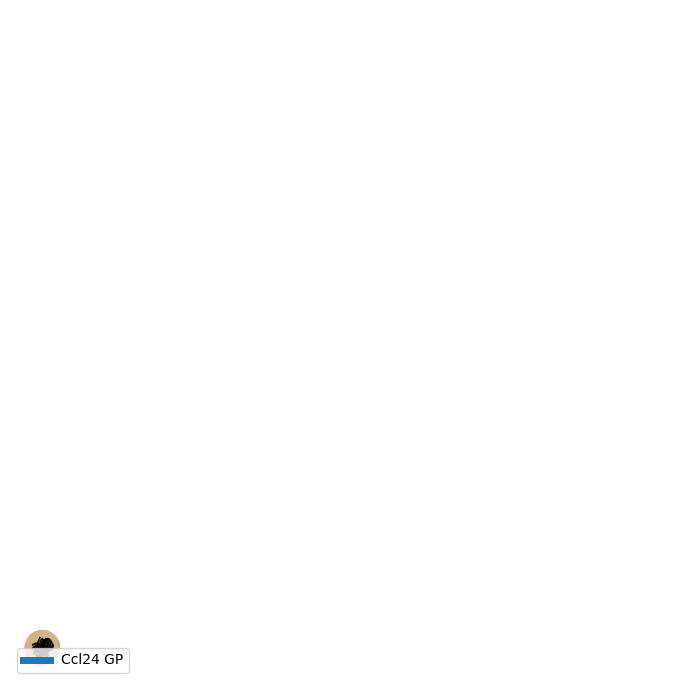

In [60]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(7, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )